# Softmax regression with $l_1$

In [5]:
!pip install ucimlrepo

In [23]:
import pandas as pd

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr

# Define softmax function
@jit
def softmax(z):
    exp_z = jnp.exp(z - jnp.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

# Define cross-entropy loss
@jit
def cross_entropy_loss_log(w, X, y):
    predictions = X @ w
    n = len(X)
    log_likelihoods = jax.scipy.special.logsumexp(predictions, axis=1)
    cross_entropy = log_likelihoods - jnp.sum(jnp.multiply(predictions, y), axis=1)
    return (1/n) * jnp.sum(cross_entropy)

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def compute_optimal(X, y, lam):
    n, d = X.shape
    k = y.shape[1]  # Assuming y is one-hot encoded, number of classes

    # Define the variable for weights
    w = cp.Variable((d, k))

    # Construct the objective
    logits = X @ w
    log_likelihoods = cp.log_sum_exp(logits, axis=1)
    cross_entropy_loss = cp.sum(log_likelihoods) - cp.sum(cp.multiply(y, logits))

    # Add l1 regularization
    l1_reg = lam * cp.sum(cp.abs(w))

    # Total loss
    loss = (1/n) * cross_entropy_loss + l1_reg

    # Define the problem
    problem = cp.Problem(cp.Minimize(loss))

    # Solve the problem
    problem.solve()

    # Extract the optimal weights and minimum loss
    w_star = w.value
    f_star = problem.value

    return w_star, f_star

def generate_problem():
    # Fetch dataset from UCI repository
    dataset = fetch_ucirepo(id=697)

    # Extract features and targets
    X = dataset.data.features.values
    y = dataset.data.targets.values.flatten()

    # Create a mapping from unique labels to integers
    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to integers using the mapping
    y_integers = jnp.array([label_to_int[label] for label in y])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_integers, test_size=0.33, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # One-hot encoding using jax
    y_train_one_hot = jax.nn.one_hot(y_train, num_classes)
    y_test_one_hot = jax.nn.one_hot(y_test, num_classes)

    return X_train, y_train_one_hot, X_test, y_test_one_hot

def subgradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)

    iter_start = time.time()
    for i in range(num_iters):
        gradF = grad(f)(w)
        subgrad = gradF + lam * jnp.sign(w)
        w -= learning_rate * subgrad
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times


def proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)
    proximal_L1 = lambda w, l: jnp.maximum(w - l, 0) - jnp.maximum(- w - l, 0)

    iter_start = time.time()
    for i in range(num_iters):
        gradF = grad(f)(w)
        w = proximal_L1(w - learning_rate * gradF, learning_rate * lam)

        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

# Compute accuracy
def compute_accuracy(w, X, y):
    predictions = softmax(X @ w)
    predicted_classes = jnp.argmax(predictions, axis=1)
    true_classes = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_classes == true_classes)
    return accuracy

# Compute metrics
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam):
    f = lambda w: cross_entropy_loss_log(w, X_train, y_train) + lam * jnp.sum(jnp.abs(w))
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "sparsity": [jnp.mean(jnp.abs(x) < 1e-5) for x in trajectory]
    }
    return metrics

def run_experiments(params):
    lam = params["lam"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem()
    n_features = X_train.shape[1]
    n_classes = len(y_train[0])
    params["n_features"], params["n_classes"] = n_features, n_classes

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, n_classes))
    x_star, f_star = compute_optimal(X_train, y_train, lam)
    print(f"Optimal accuracy {compute_accuracy(x_star, X_train, y_train)}")

    for method in methods:
        if method["method"] == "Subgrad":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = subgradient_descent(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    lam = params["lam"]

    plt.suptitle(f"Convex multiclass regression. lam={lam}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method + f" sparsity {metrics['sparsity'][-1]:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{lam}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

Optimal accuracy 0.7763157486915588


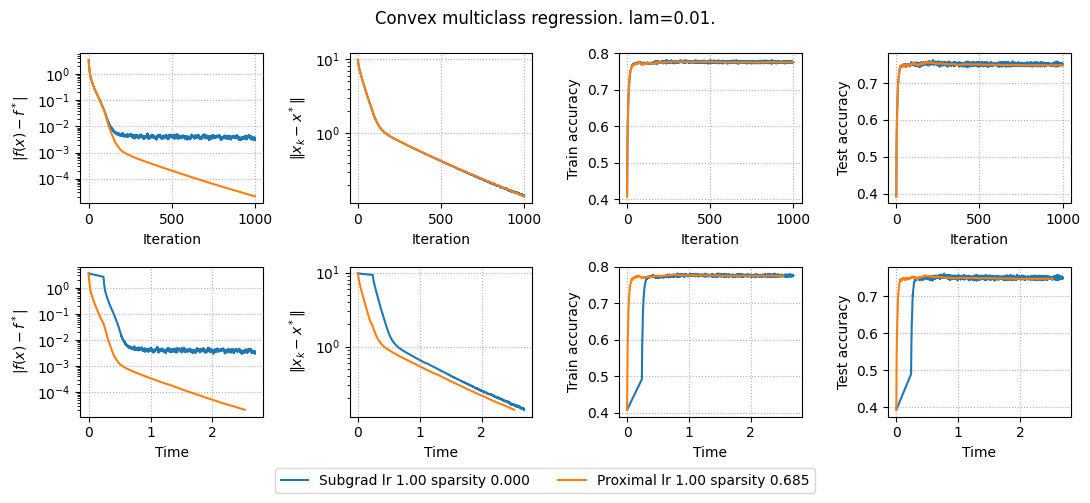

In [11]:
params = {
    "lam": 1e-2,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1,
            "iterations": 1000,
        },
        {
            "method": "Proximal",
            "learning_rate": 1,
            "iterations": 1000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

# Пункт 2



Optimal accuracy 0.7817139029502869


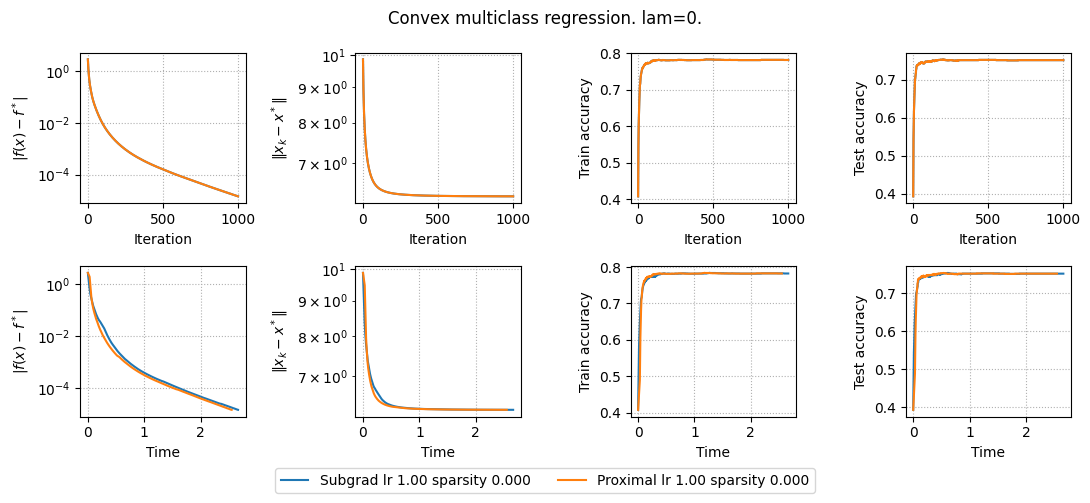

In [12]:
params = {
    "lam": 0,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1,
            "iterations": 1000,
        },
        {
            "method": "Proximal",
            "learning_rate": 1,
            "iterations": 1000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Для подбора шага будем смотреть на графики сходимости

Subgradient:

LR = 0.1
Optimal accuracy 0.7817139029502869


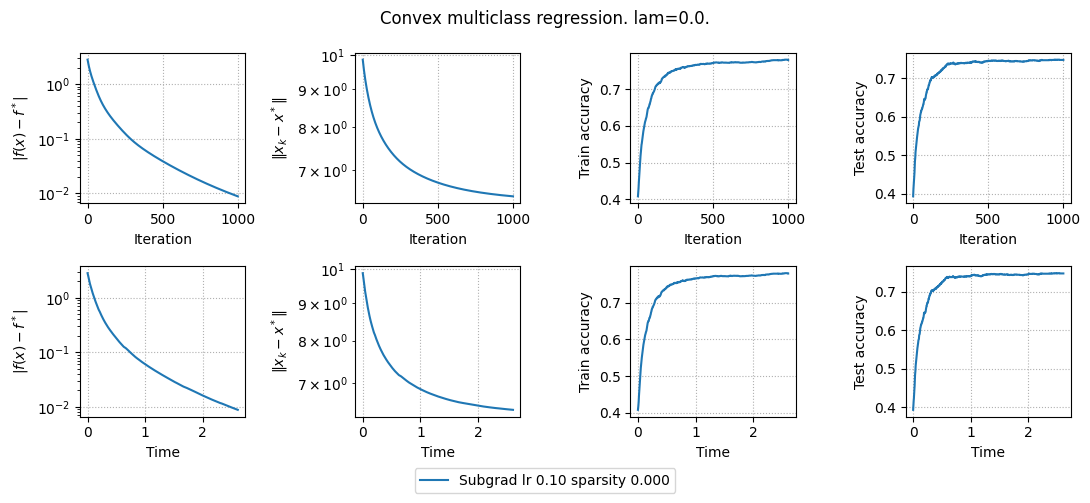

LR = 0.1
Optimal accuracy 0.7817139029502869


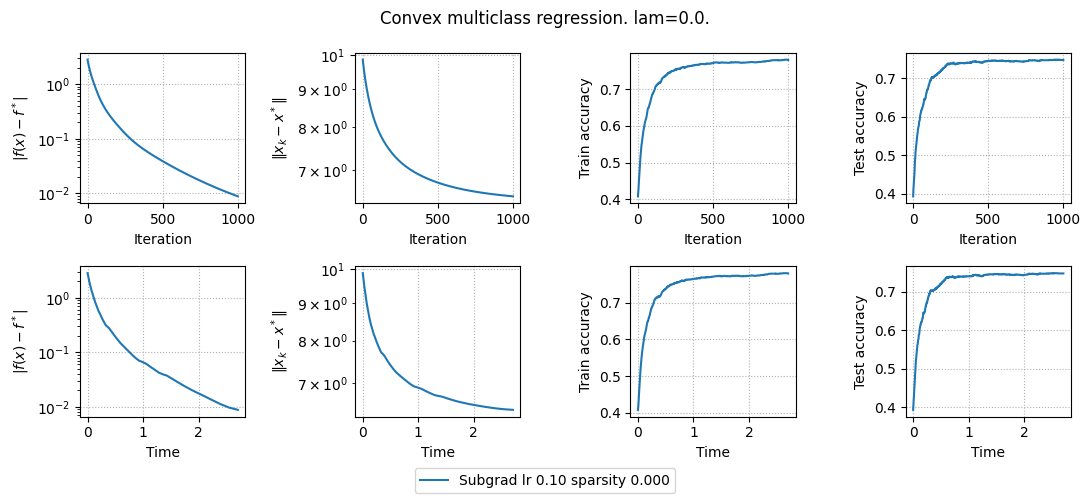

LR = 0.2
Optimal accuracy 0.7817139029502869


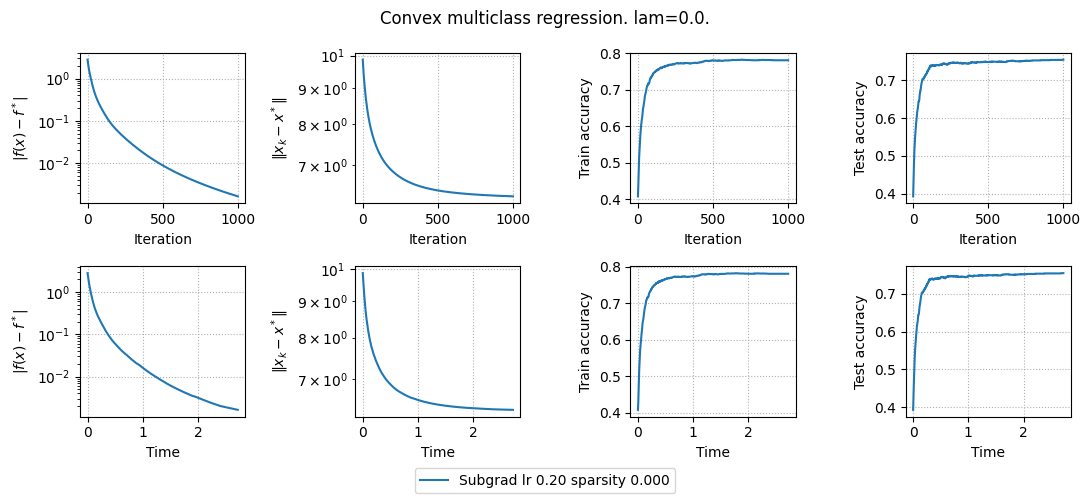

LR = 0.5
Optimal accuracy 0.7817139029502869


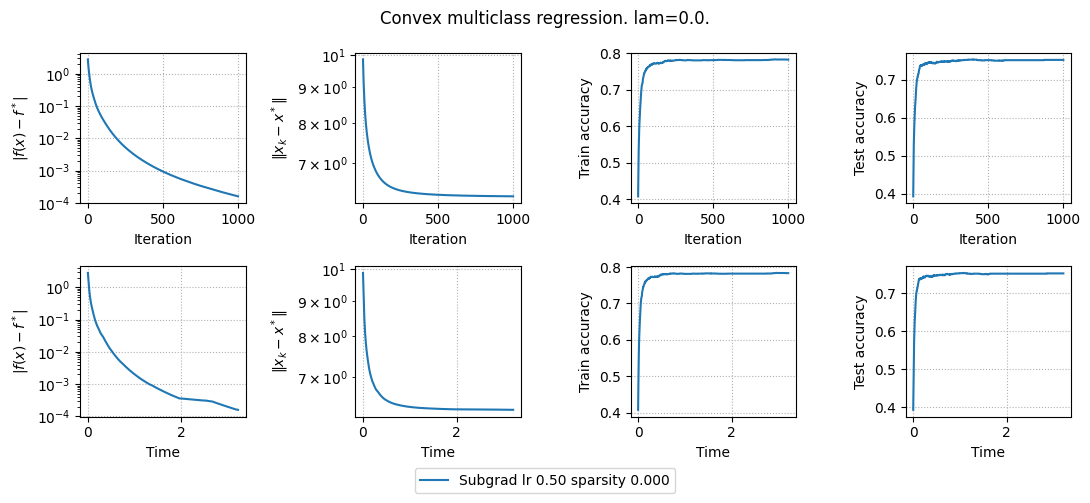

LR = 0.8
Optimal accuracy 0.7817139029502869


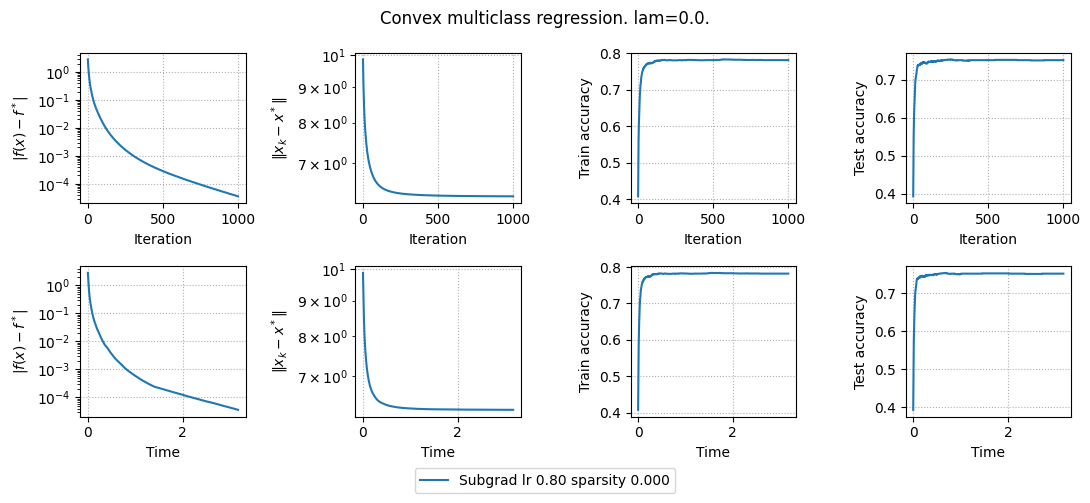

LR = 1
Optimal accuracy 0.7817139029502869


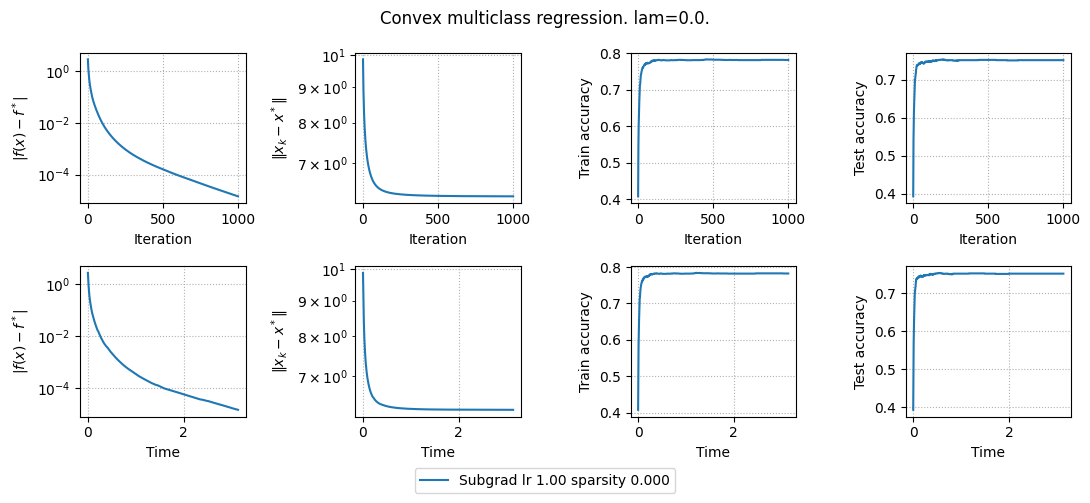

LR = 1.5
Optimal accuracy 0.7817139029502869


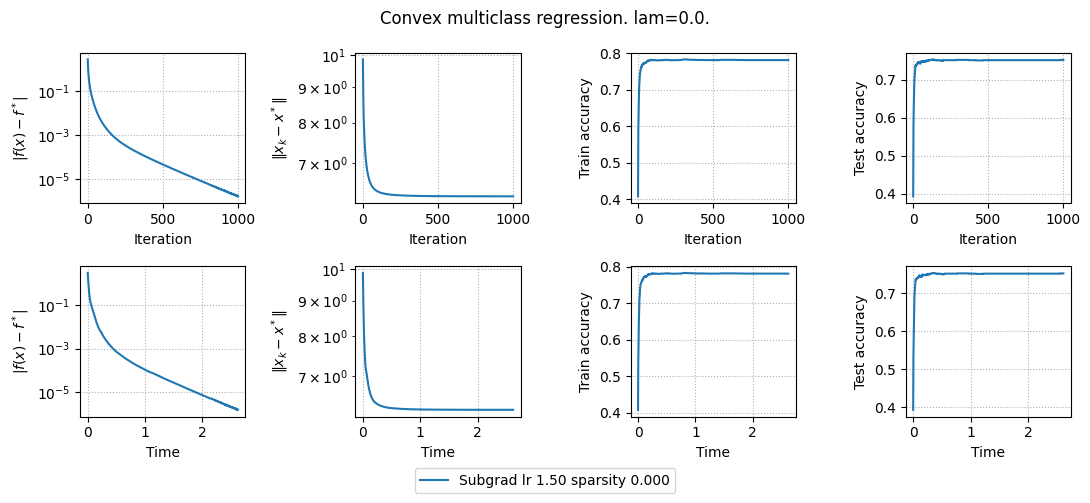

LR = 4
Optimal accuracy 0.7817139029502869


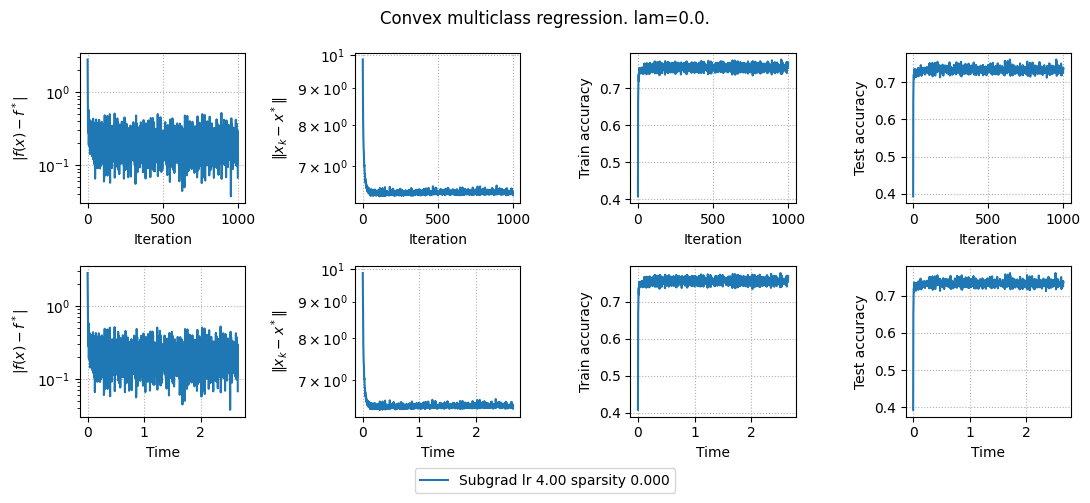

In [17]:
lrs = [1e-1, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 4]
for lr in lrs:
    print(f"LR = {lr}")
    params = {
        "lam": 0.0,
        "methods": [
            {"method": "Subgrad",
              "learning_rate": lr,
              "iterations": 1000}
        ]
    }
    results, params = run_experiments(params)
    plot_results(results, params)


Получилось, что при большем шаге сходится быстрее, при больших шагах локальный минимум отдаляется. Поэтому идеальный вариант - 1.5

Proximal:

LR = 0.1
Optimal accuracy 0.7817139029502869


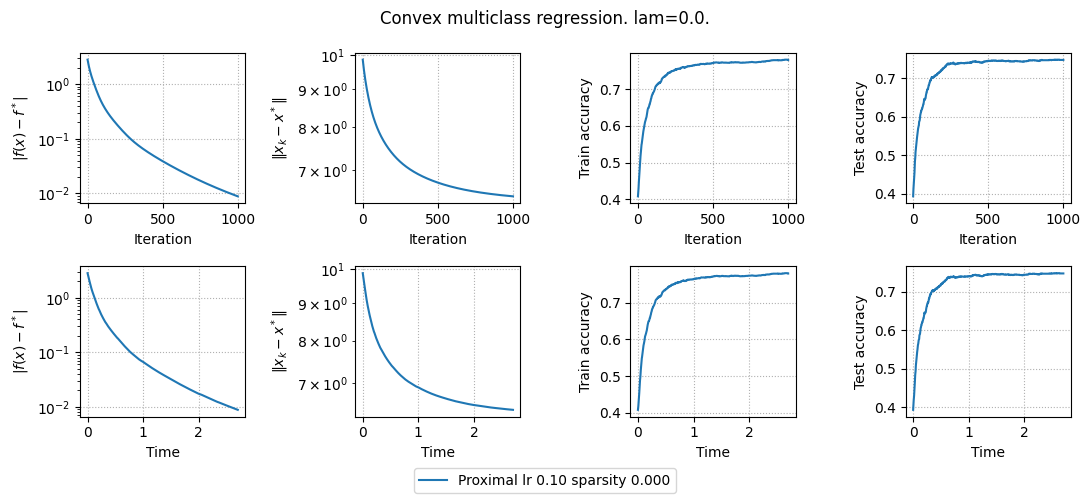

LR = 0.1
Optimal accuracy 0.7817139029502869


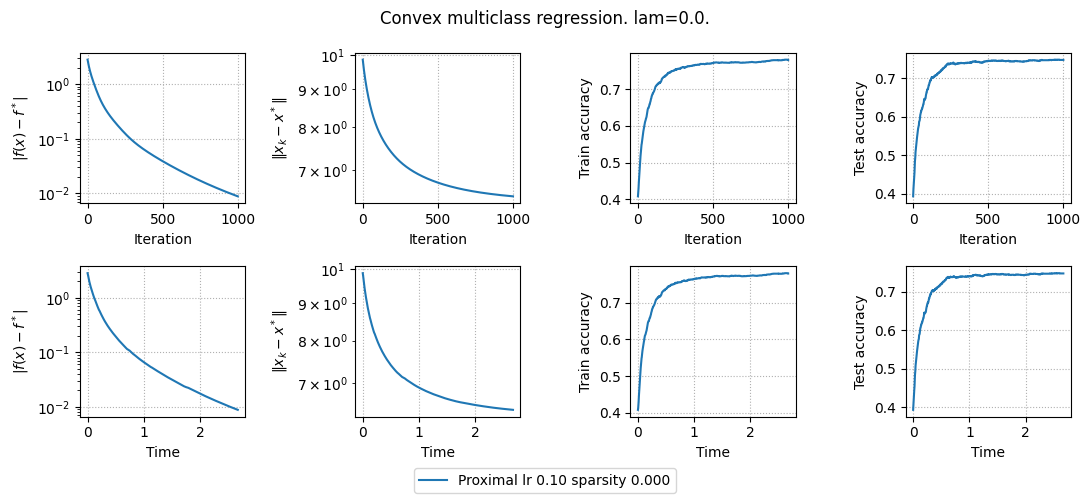

LR = 0.2
Optimal accuracy 0.7817139029502869


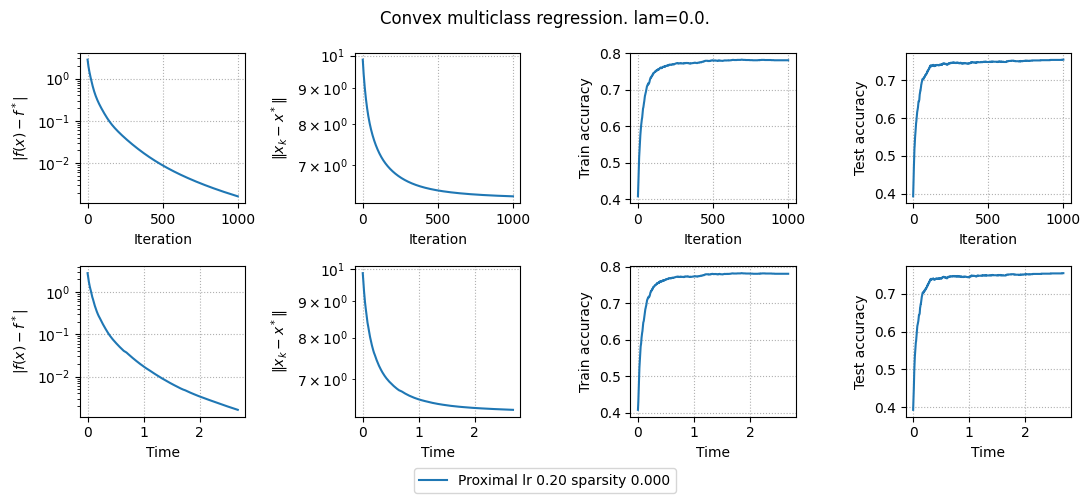

LR = 0.5
Optimal accuracy 0.7817139029502869


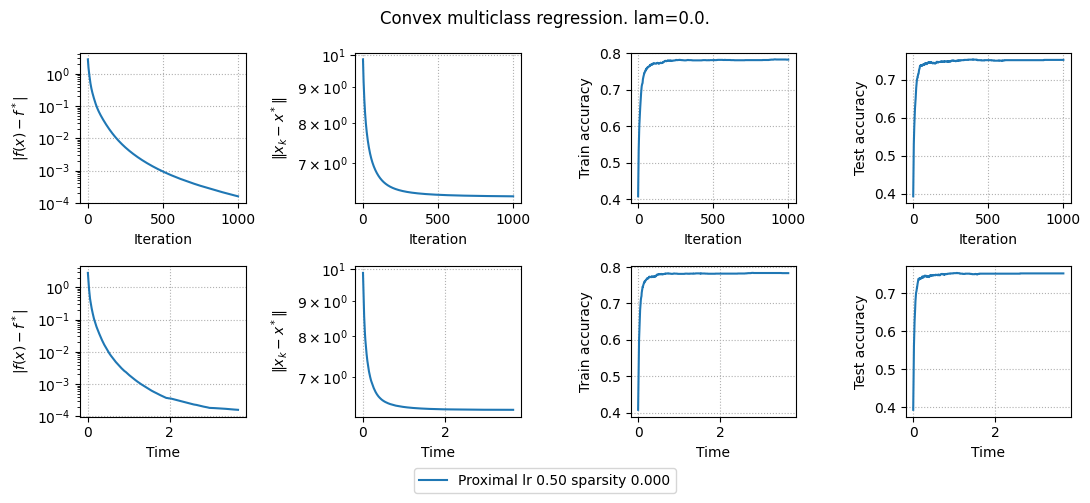

LR = 0.8
Optimal accuracy 0.7817139029502869


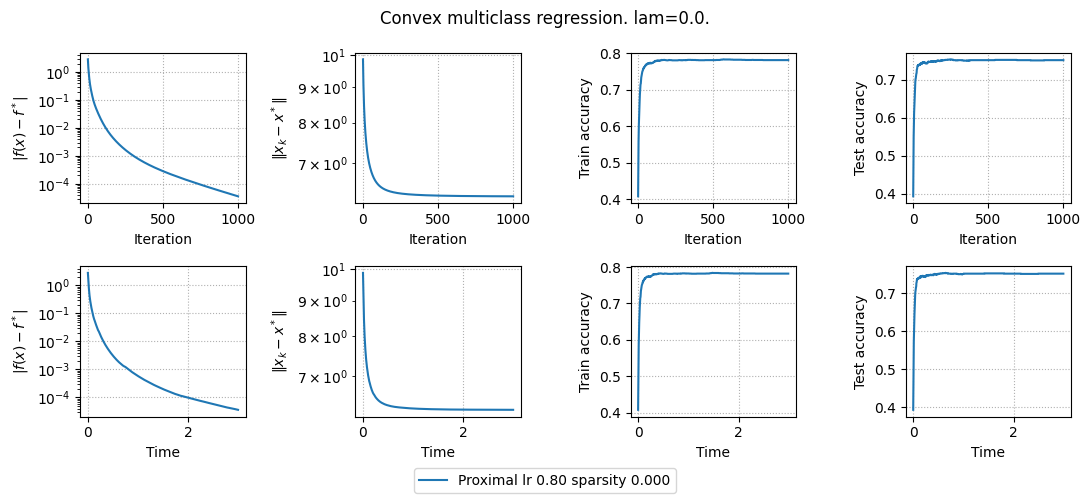

LR = 1
Optimal accuracy 0.7817139029502869


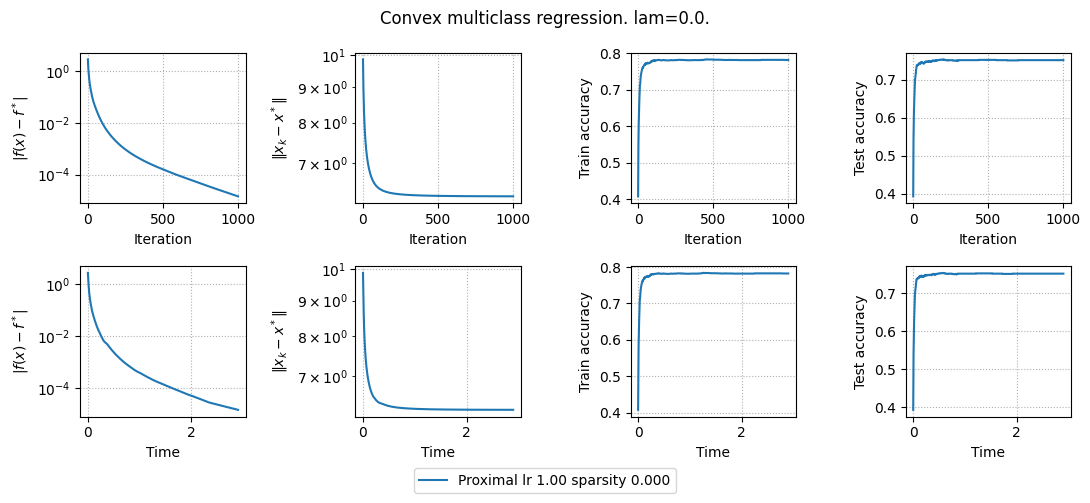

LR = 1.5
Optimal accuracy 0.7817139029502869


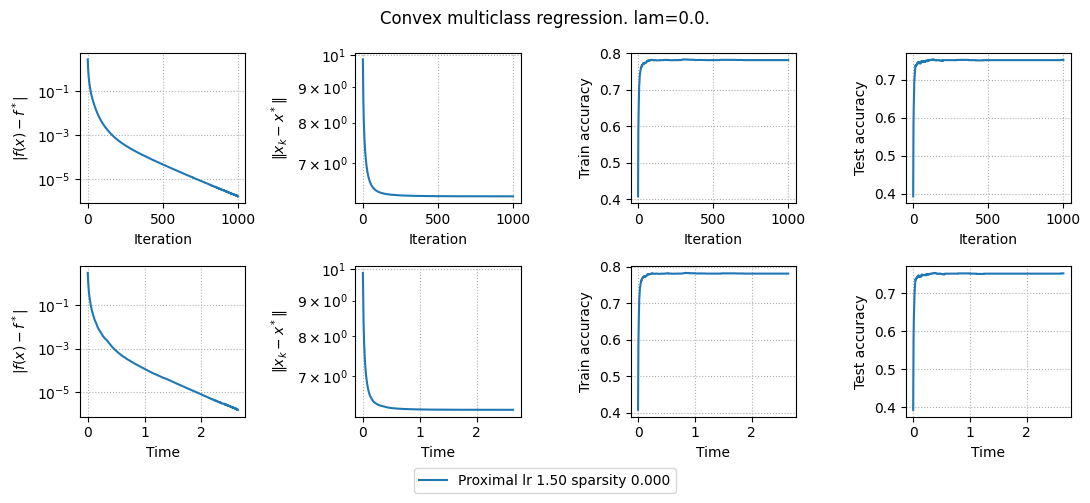

LR = 4
Optimal accuracy 0.7817139029502869


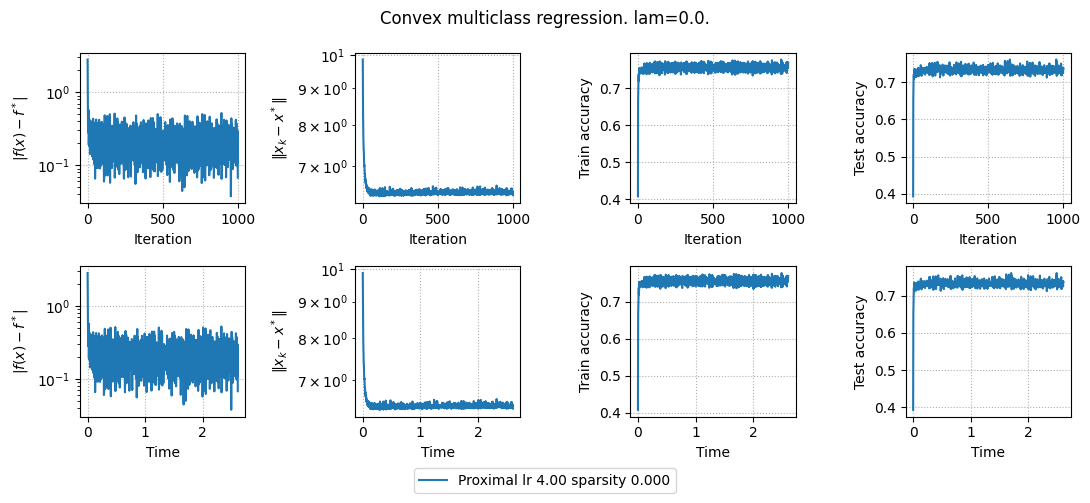

In [18]:
for lr in lrs:
    print(f"LR = {lr}")
    params = {
        "lam": 0.0,
        "methods": [
            {"method": "Proximal",
              "learning_rate": lr,
              "iterations": 1000}
        ]
    }
    results, params = run_experiments(params)
    plot_results(results, params)


Здесь получили аналогичну ситуацию, поэтому выбираем для обоих методов 1.5

Optimal accuracy 0.7817139029502869


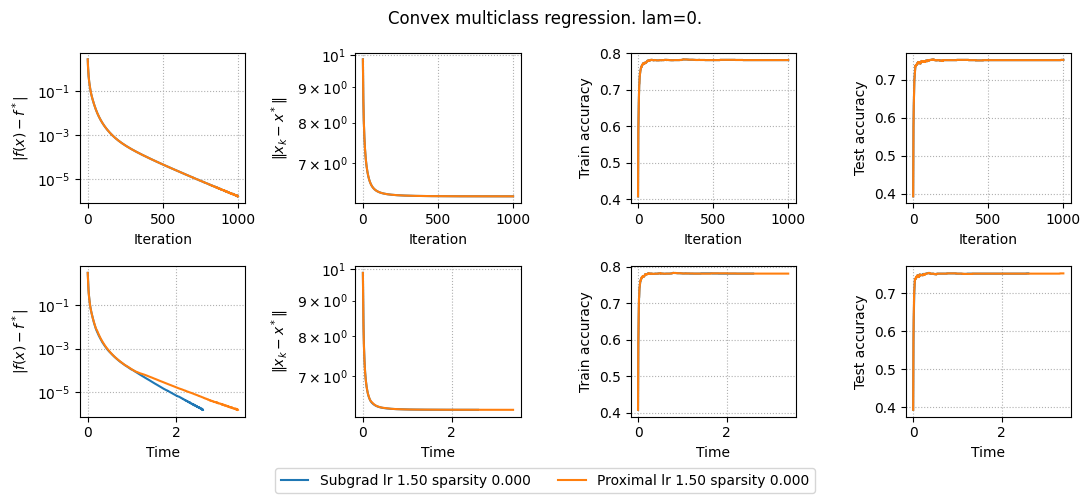

In [19]:
params = {
    "lam": 0,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1.5,
            "iterations": 1000,
        },
        {
            "method": "Proximal",
            "learning_rate": 1.5,
            "iterations": 1000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

In [21]:
for i, j in results.items():
    final_sparsity = j["sparsity"][-1]
    print(f"{i}. Sparsity: {final_sparsity:.4f}")


Subgrad lr 1.50. Sparsity: 0.0000
Proximal lr 1.50. Sparsity: 0.0000


#Пункт 3

Перепишем исходную таблицу в список

In [22]:
data = [
    ("Subgrad", 1.5, 1e-1, 1e-2),
    ("Subgrad", 1.5, 1e-2, 1e-2),
    ("Subgrad", 1.5, 1e-3, 1e-2),
    ("Subgrad", 1.5, 1e-4, 1e-2),
    ("Subgrad", 1.5, 1e-5, 1e-2),

    ("Proximal", 1.5, 1e-1, 1e-2),
    ("Proximal", 1.5, 1e-2, 1e-2),
    ("Proximal", 1.5, 1e-3, 1e-2),
    ("Proximal", 1.5, 1e-4, 1e-2),
    ("Proximal", 1.5, 1e-5, 1e-2),

    ("Subgrad", 1.5, 1e-2, 1e-3),
    ("Proximal", 1.5, 1e-2, 1e-3),

    ("Subgrad", 1.5, 1e-2, 1e-1),
    ("Proximal", 1.5, 1e-2, 1e-1),

    ("Subgrad", 1.5, 1e-2, 1.0),
    ("Proximal", 1.5, 1e-2, 1.0),
]


In [26]:
res = []
for method, lr, eps, lam in data:
    params = {
        "lam": lam,
        "methods": [
            {"method": method,
              "learning_rate": lr,
              "iterations": 2000}
        ]
    }

    results, _ = run_experiments(params)
    method_key = list(results.keys())[0]
    metrics = results[method_key]
    iter_idx = -1
    for i in range(len(metrics["f_gap"])):
        if metrics["f_gap"][i] < eps:
            iter_idx = i
            break

    res.append({
        "method": method,
        "lr": lr,
        "eps": eps,
        "iter_val": iter_idx if iter_idx != -1 else 2000,
        "comment": "",
        "sparsity": metrics["sparsity"][-1],
        "lam": lam,
        "test_acc": metrics["test_acc"][-1]
    })

print(pd.DataFrame(res).head(15))


Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7763157486915588
Optimal accuracy 0.7827260494232178
Optimal accuracy 0.7827260494232178
Optimal accuracy 0.7371794581413269
Optimal accuracy 0.7371794581413269
Optimal accuracy 0.31545206904411316
Optimal accuracy 0.31545206904411316
      method   lr      eps  iter_val comment    sparsity    lam    test_acc
0    Subgrad  1.5  0.10000        47                 0.0  0.010   0.7424658
1    Subgrad  1.5  0.01000      2000                 0.0  0.010   0.7424658
2    Subgrad  1.5  0.00100      2000                 0.0  0.010   0.7424658
3    Subgrad  1.5  0.00010      2000                 0.0  0.010   0.7424658
4    Subgrad  1.5  0.00001      2000      

#Stochastic gradient methods

#Variance reduction for stochastic gradient methods

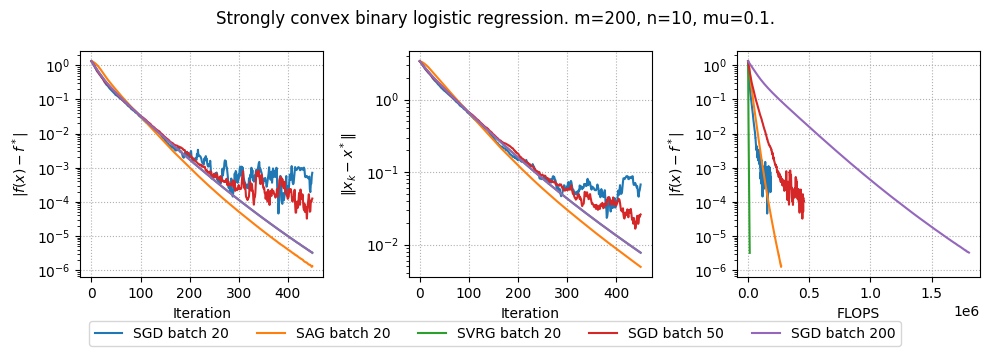

In [32]:
params = {
    "mu": 1e-1,
    "m": 200,
    "n": 10,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-1,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-1,
            "epoch_length": 3,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 50,
            "iterations": 450,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 200,
            "iterations": 450,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

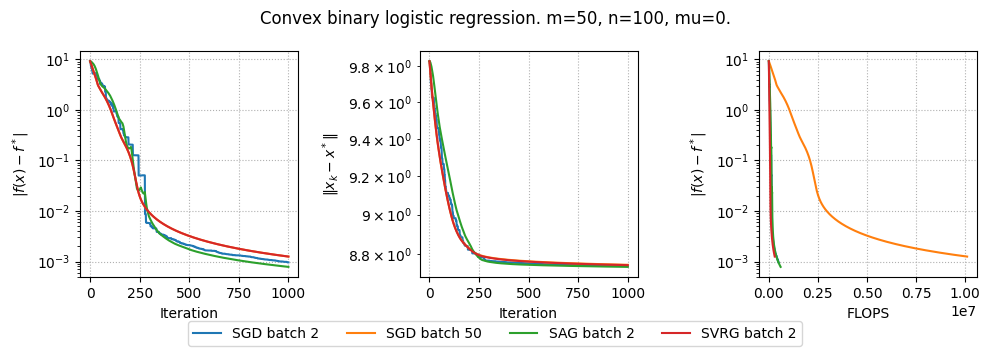

In [29]:
params = {
    "mu": 0,
    "m": 50,
    "n": 100,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 1000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 50,
            "iterations": 1000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 1000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 2,
            "batch_size": 2,
            "iterations": 1000,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

В целом особо сильной разницы здесь нет, только у SVRG и SAG более гладкая и стабильная функция

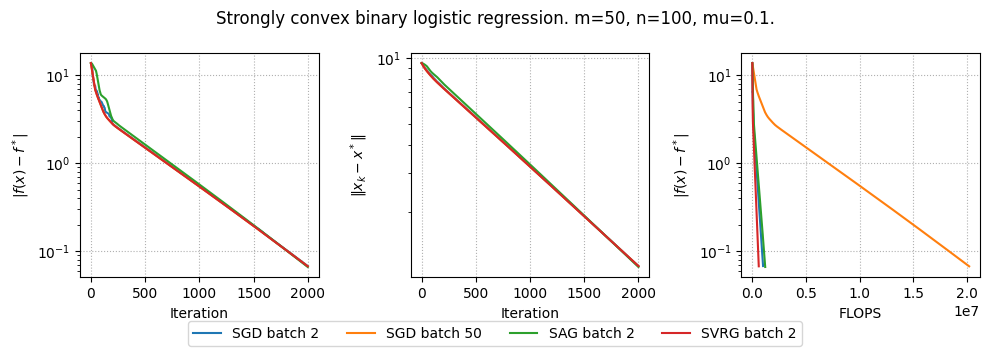

In [35]:
params = {
    "mu": 1e-1,
    "m": 50,
    "n": 100,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 50,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 2,
            "batch_size": 2,
            "iterations": 2000,
        },
    ]
}
results = run_experiments(params)
plot_results(results, params)

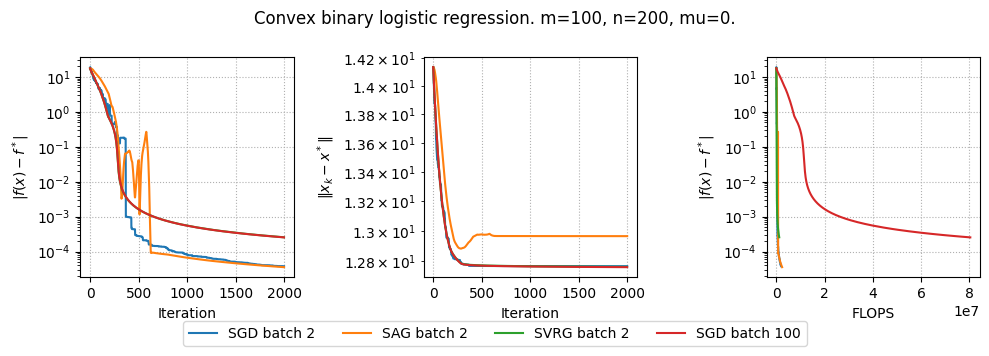

In [38]:
params = {
    "mu": 0,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-2,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 2000,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-2,
            "batch_size": 100,
            "iterations": 2000,
        },
    ]
}
results = run_experiments(params)
plot_results(results, params)

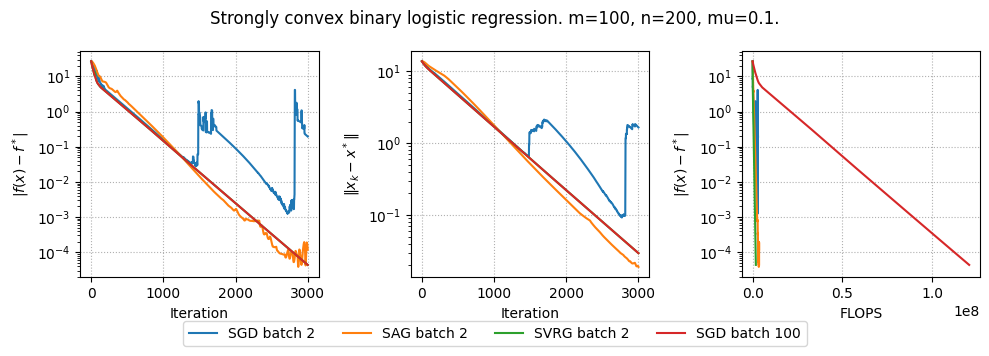

In [36]:
params = {
    "mu": 1e-1,
    "m": 100,
    "n": 200,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SAG",
            "learning_rate": 2e-2,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SVRG",
            "learning_rate": 2e-2,
            "epoch_length": 3,
            "batch_size": 2,
            "iterations": 3000,
        },
        {
            "method": "SGD",
            "learning_rate": 2e-2,
            "batch_size": 100,
            "iterations": 3000,
        },
    ]
}
results = run_experiments(params)
plot_results(results, params)

Главные выводы:

SAG и SVRG почти всегда быстрее SGD при правильных гиперпараметрах.

SGD с малым батчем хорош на начальных итерациях, но потом проигрывает.

SGD с большим батчем слишком медленный для стохастической оптимизации.

Регуляризация (mu > 0) ускоряет сходимость SAG/SVRG.

____
# Блок Neural network training

# Timeseries anomaly detection using an Autoencoder

## Setup

In [3]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## Load the data

In [4]:
import plotly.graph_objs as go
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df.index, y=df['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
markers = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down']
for (label, date), marker in zip(anomalies.items(), markers):
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Show the figure
# Config for the plot
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

## Data preprocessing

* We need to split the data to the normal one and the data with anomalies.
* For this reason we skip the data with anomalies +- 1 day

In [5]:
import pandas as pd
import plotly.graph_objs as go
from datetime import timedelta

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Convert anomaly dates to datetime
anomaly_dates = [pd.to_datetime(date) for date in anomalies.values()]

# Function to split the data into continuous segments
def split_data(data, anomaly_dates, window=timedelta(days=1)):
    segments = []
    current_segment = []
    for date, row in data.iterrows():
        if any(abs(date - anomaly_date) <= window for anomaly_date in anomaly_dates):
            if current_segment:
                segments.append(pd.DataFrame(current_segment))
                current_segment = []
        else:
            current_segment.append(row)
    if current_segment:
        segments.append(pd.DataFrame(current_segment))
    return segments

# Split the normal data
normal_segments = split_data(df, anomaly_dates)

# Split the anomaly data
anomaly_window = timedelta(days=1)
anomaly_segments = []
for anomaly_date in anomaly_dates:
    segment = df[(df.index >= anomaly_date - anomaly_window) & (df.index <= anomaly_date + anomaly_window)]
    anomaly_segments.append(segment)

# Create the plot
fig = go.Figure()

# Add the normal data segments with legendgroup
for i, segment in enumerate(normal_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Normal Data' if i == 0 else None,
        legendgroup='Normal Data',
        line=dict(color='blue'),
        showlegend=i == 0
    ))

# Add the anomaly data segments with legendgroup
for i, segment in enumerate(anomaly_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Anomaly Data' if i == 0 else None,
        legendgroup='Anomaly Data',
        line=dict(color='red'),
        showlegend=i == 0
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Config for the plot
config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=config)


## Create dataset
Let's create a dataset from the normal data to train autoencoder model

For this reason we have to

1. Normalize the data by subtracting mean value and dividing by the std
2. Define variable TIME_STEPS = 25 and we split the data points with the chunks of this size (without overlapping normal segments) and put it to the array x_train of the shape (*, TIME_STEPS) where * indicates the total amount of resulting chunks.

In [6]:
df_normalized = df
df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()
# Split the normal data
normal_segments = split_data(df_normalized, anomaly_dates)

# Normalize each segment separately
def normalize_segment(segment):
    mean_value = segment['value'].mean()
    std_value = segment['value'].std()
    return (segment['value'] - mean_value) / std_value

normalized_segments = [normalize_segment(segment) for segment in normal_segments]

# Define the TIME_STEPS
TIME_STEPS = 100

# Function to create overlapping chunks from each segment
def create_chunks(segment, time_steps):
    chunks = []
    segment_values = segment.values
    for i in range(len(segment_values) - time_steps + 1):
        chunks.append(segment_values[i: i + time_steps])
    return chunks

# Create chunks from each normalized segment
x_train = []
x_full = []
for segment in normalized_segments:
    x_train.extend(create_chunks(segment, TIME_STEPS))

x_full = create_chunks(df_normalized, TIME_STEPS)

x_train = np.array(x_train)
x_full = np.array(x_full)[:,:,0]

# Print the shape of x_train
print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')

x_train shape: (9241, 100)
x_full shape: (10221, 100)


## Build a model

In [7]:
x_train = x_train.reshape((-1, TIME_STEPS, 1))
x_full = x_full.reshape((-1, TIME_STEPS, 1))

print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')


import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

# Define the autoencoder model
class Autoencoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(7,))(x)
        return x

# Initialize model
rng = jax.random.PRNGKey(0)
input_shape = (128, TIME_STEPS, 1)
x = jnp.ones(input_shape)
model = Autoencoder()
params = model.init(rng, x)
output = model.apply(params, x_train)
print(f"Model output shape {output.shape}")
print(model.tabulate(jax.random.key(0), x,
                   compute_flops=True, compute_vjp_flops=True))

x_train shape: (9241, 100, 1)
x_full shape: (10221, 100, 1)
Model output shape (9241, 100, 1)

                              Autoencoder Summary                               
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs   ┃ outputs   ┃ flops    ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│          │ Autoenc… │ float32… │ float32[… │ 2391864… │ 716327168 │          │
├──────────┼──────────┼──────────┼───────────┼──────────┼───────────┼──────────┤
│ Conv_0   │ Conv     │ float32… │ float32[… │ 6045696  │ 17727712  │ bias:    │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │          │           │ kernel:  │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │          │           │          │
│          │  

## Train the model

100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


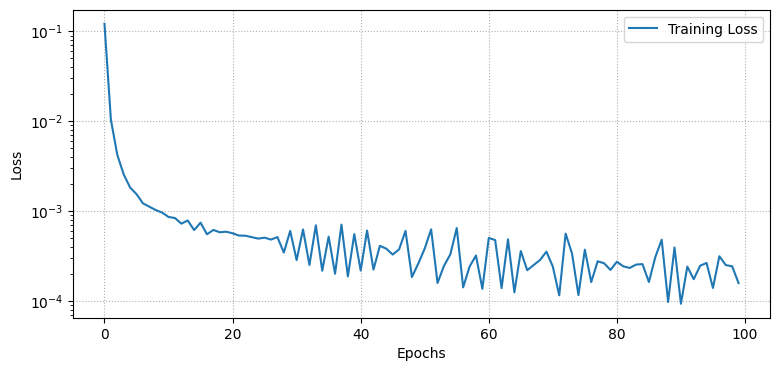

In [8]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.nadam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


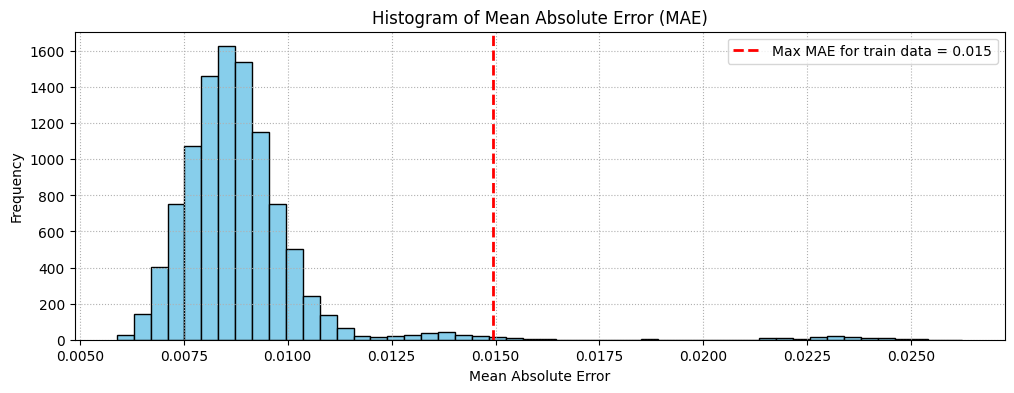

In [9]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()


### Compare recontruction

Just for fun, let's see how our model has recontructed the random sample from the dataset.

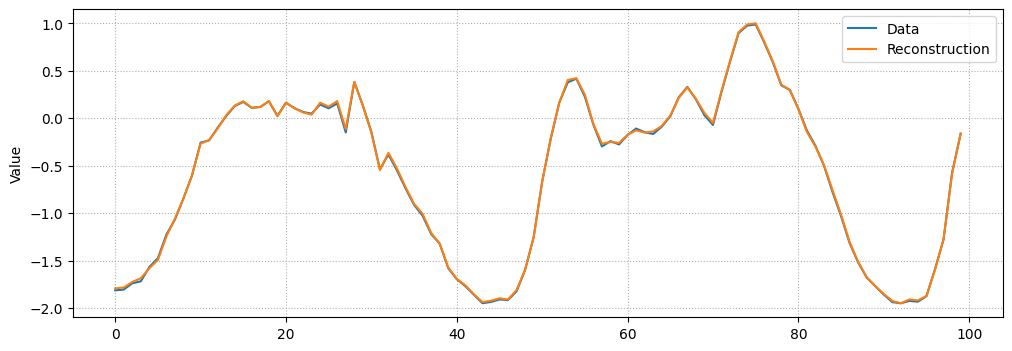

In [10]:
# Checking how the first sequence is learnt
index = np.random.randint(len(x_full))

plt.figure(figsize=(12, 4))
plt.plot(x_full[index], label="Data")
prediction =  model.apply(state.params, x_full[index])
plt.plot(prediction, label="Reconstruction")
plt.ylabel("Value")
plt.xlabel("")
plt.legend()
plt.grid(linestyle=":")
plt.show()

## Plot anomalies

In [11]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='red'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

# Exercise:

The default solution is nadam and after training it can detect 4 out of 5 anomalies. Train any other method(s), which ensures at least detecting 3 out of 5 anomalies while being approximately the same on the final train loss.

You can use any default optimizer from [optax](https://optax.readthedocs.io/en/latest/api/optimizers.html) or learning rate [schedulers](https://optax.readthedocs.io/en/latest/api/optimizer_schedules.html).

In [18]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
from functools import partial
from sklearn.preprocessing import RobustScaler
from datetime import timedelta

# 1. Функция для создания последовательностей
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i:(i + time_steps)])
    return np.array(output)

# 2. Загрузка и подготовка данных
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Определение аномалий
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# 3. Нормализация данных
scaler = RobustScaler()
df_normalized = df.copy()
df_normalized['value'] = scaler.fit_transform(df[['value']])

# 4. Создание меток и выделение нормальных данных
def mark_anomalies(df, anomalies_dict, window_size=24):
    df['label'] = 0
    anomaly_window = timedelta(hours=window_size)
    for date in anomalies_dict.values():
        anomaly_date = pd.to_datetime(date)
        start = anomaly_date - anomaly_window
        end = anomaly_date + anomaly_window
        df.loc[(df.index >= start) & (df.index <= end), 'label'] = 1
    return df

df_labeled = mark_anomalies(df_normalized, anomalies)
normal_data = df_labeled[df_labeled['label'] == 0]['value'].values

# 5. Создание последовательностей
TIME_STEPS = 24  # Размер окна (24 часа)
x_train = create_sequences(normal_data, TIME_STEPS)
x_full = create_sequences(df_normalized['value'].values, TIME_STEPS)
x_train = x_train.reshape((-1, TIME_STEPS, 1))
x_full = x_full.reshape((-1, TIME_STEPS, 1))

# 6. Архитектура модели LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    latent_dim: int = 16

    @nn.compact
    def __call__(self, x):
        # Encoder
        x, _ = nn.LSTM(self.latent_dim, return_carry=True)(x)
        # Decoder
        x, _ = nn.LSTM(self.latent_dim, return_carry=True)(x)
        x = nn.Dense(1)(x)  # Выходной размер 1
        return x

# 7. Функция обучения
def train_model(optimizer_fn, optimizer_name, x_train, n_epochs=150, batch_size=64, learning_rate=1e-4):
    rng = jax.random.PRNGKey(42)
    model = LSTMAutoencoder()
    dummy_input = jnp.ones((batch_size, TIME_STEPS, 1))
    params = model.init(rng, dummy_input)
    tx = optimizer_fn(learning_rate)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    @jax.jit
    def train_step(state, batch):
        def loss_fn(params):
            reconstruction = model.apply(params, batch)
            return jnp.mean(jnp.abs(batch - reconstruction))
        loss, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss

    losses = []
    for epoch in tqdm(range(n_epochs), desc=f"{optimizer_name} Training"):
        perm = np.random.permutation(len(x_train))
        epoch_loss = 0
        count = 0
        for i in range(0, len(perm), batch_size):
            batch_idx = perm[i:i + batch_size]
            if len(batch_idx) < batch_size:
                continue
            x_batch = x_train[batch_idx]
            state, loss = train_step(state, x_batch)
            epoch_loss += loss
            count += 1
        losses.append(epoch_loss / count if count > 0 else 0)

    # Предсказание для всего набора
    predictions = []
    for i in range(0, len(x_full), batch_size):
        batch = x_full[i:i + batch_size]
        if len(batch) < batch_size:
            continue
        pred = model.apply(state.params, batch)
        predictions.append(pred)
    predictions = jnp.concatenate(predictions, axis=0)
    return state, losses, predictions

# 8. Функция оценки аномалий
def evaluate_anomalies(predictions, x_full, anomalies_dict, window_size=TIME_STEPS):
    errors = jnp.mean(jnp.abs(predictions - x_full), axis=(1,2))
    mean_errors = jnp.convolve(errors, jnp.ones(30)/30, mode='same')
    std_errors = jnp.sqrt(jnp.convolve((errors-mean_errors)**2, jnp.ones(30)/30, mode='same'))
    threshold = mean_errors + 3*std_errors

    detected = []
    for name, date in anomalies_dict.items():
        idx = np.searchsorted(df_normalized.index, pd.to_datetime(date)) // window_size
        if idx < len(errors) and errors[idx] > threshold[idx]:
            detected.append(name)
    return detected, errors, threshold

# 9. Обучение и оценка
optimizers = {
    "Adam": optax.adam,
    "Nadam": optax.nadam,
    "AdamW": optax.adamw,
    "RAdam": optax.radam
}

results = {}
for name, opt_fn in optimizers.items():
    state, losses, predictions = train_model(
        opt_fn, name, x_train,
        n_epochs=150,
        batch_size=64,
        learning_rate=1e-4
    )
    detected, errors, threshold = evaluate_anomalies(predictions, x_full, anomalies)
    results[name] = {
        'state': state,
        'losses': losses,
        'predictions': predictions,
        'detected': detected,
        'errors': errors,
        'threshold': threshold
    }
    print(f"{name}: Detected {len(detected)}/5 anomalies: {detected}")

# 10. Визуализация результатов
for name, result in results.items():
    fig = go.Figure()

    # Исходные данные
    fig.add_trace(go.Scatter(
        x=df_normalized.index,
        y=df_normalized['value'],
        mode='lines',
        name='Taxi Passengers'
    ))

    # Известные аномалии
    for label, date in anomalies.items():
        fig.add_trace(go.Scatter(
            x=[date],
            y=[df_normalized.loc[date]['value']],
            mode='markers+text',
            name=label,
            text=label,
            textposition="top center",
            marker=dict(symbol='circle', size=10, color='red')
        ))

    # Обнаруженные аномалии
    anomaly_indices = np.where(result['errors'] > result['threshold'])[0]
    for i in anomaly_indices[:50]:  # Ограничиваем количество для визуализации
        date = df_normalized.index[int(i + TIME_STEPS/2)]
        fig.add_trace(go.Scatter(
            x=[date],
            y=[df_normalized.loc[date]['value']],
            mode='markers',
            name='Detected Anomaly' if i == anomaly_indices[0] else None,
            marker=dict(symbol='x', size=8, color='blue'),
            showlegend=(i == anomaly_indices[0])
        ))

    fig.update_layout(
        title=f'Anomaly Detection with {name} (Detected {len(result["detected"])}/5)',
        xaxis_title='Date',
        template='plotly_white'
    )
    fig.show()

AttributeError: module 'flax.linen' has no attribute 'LSTM'

#ADMM (Dual methods)

### Пункт а

**Можем так переформулировать задачу:**

$
min_{X, Z} \frac{1}{2}\|P_\Omega(Z - M)\|_F^2 + \lambda\|X\|_* \quad \text{S.T} \quad X - Z = 0
$

**Выпишем Лагражиан:**

$
{L}_\rho(X, Z, Y) = \frac{1}{2}\|P_\Omega(Z - M)\|_F^2 + \lambda\|X\|_* + \langle Y, X-Z \rangle + \frac{\rho}{2}\|X-Z\|_F^2
$
где:
- \( Y \) двойственная переменная
- \( \rho > 0 \) параметр штрафа

**ADMM Updates:**

1. **X-update (SVT operation):**

$
X^{k+1} = \arg\min_X \lambda\|X\|_* + \frac{\rho}{2}\|X - Z^k + \frac{Y^k}{\rho}\|_F^2
$

$
X^{k+1} = \text{SVT}_{\lambda/\rho}\left(Z^k - \frac{Y^k}{\rho}\right)
$

2. **Z-update:**

$
Z^{k+1} = \arg\min_Z \frac{1}{2}\|P_\Omega(Z - M)\|_F^2 + \frac{\rho}{2}\|X^{k+1} - Z + \frac{Y^k}{\rho}\|_F^2
$

$
Z^{k+1}_{ij} = \begin{cases}
\frac{M_{ij} + \rho(X^{k+1}_{ij} + Y^k_{ij}/\rho)}{1 + \rho} & \text{if } (i,j) \in \Omega \\
X^{k+1}_{ij} + \frac{Y^k_{ij}}{\rho} & \text{otherwise}
\end{cases}
$

3. **Dual Update:**
$
Y^{k+1} = Y^k + \rho(X^{k+1} - Z^{k+1})
$

**Stopping Criterion:**
Terminate when:
$
\max(\|r_p^k\|_F, \|r_d^k\|_F) \leq \epsilon \quad (e.g., \epsilon=10^{-3})
$
where:
- $ r_p^k = X^k - Z^k $ (primal residual)
- $ r_d^k = \rho(Z^k - Z^{k-1}) $ (dual residual)